In [611]:
import sys
import torch
sys.path.append('../')

# Reference

In [612]:
from humancompatible.interconnect.simulators.nodes.reference import ReferenceSignal

refsig = ReferenceSignal(name="r")
refsig.set_reference_signal(0.3)

# Aggregator

In [613]:
from humancompatible.interconnect.simulators.nodes.aggregator import Aggregator

class AggregatorLogic1:
    def __init__(self):
        self.tensors = []
        self.result = None
        
    def forward(self, values):
        if type(values) is not list:
            values = [values]
        self.tensors = values
        result = torch.sum(torch.stack([torch.sum(torch.tensor([t.item()], requires_grad=False)) for t in self.tensors])).unsqueeze(dim=0)
        result = torch.tensor([result], requires_grad=True)
        self.result = result
        return result

class AggregatorLogic2:
    def __init__(self):
        self.tensors = []
        
    def forward(self, values):
        if type(values) is not list:
            values = [values]
        self.tensors = values
        result = torch.sum(torch.stack([torch.sum(t) for t in self.tensors])).unsqueeze(dim=0) 
        return result
    
agg1 = Aggregator(name="Err_A", logic=AggregatorLogic1())
agg2 = Aggregator(name="Pop_A", logic=AggregatorLogic2())

# Controller

In [614]:
from humancompatible.interconnect.simulators.nodes.controller import Controller

class PiControllerLogic:
    def __init__(self, kp, ki):
        self.tensors = {"kp": torch.tensor([kp], requires_grad=True, dtype=torch.float), 
                        "ki": torch.tensor([ki], requires_grad=True, dtype=torch.float),
                        "e": torch.tensor([0.0], requires_grad=True),
                        "x": torch.tensor([0.0], requires_grad=True)}
        self.variables = ["e"]
    
    def forward(self, values):
        self.tensors["e"] = values["e"]
        result = ( (self.tensors["kp"] * self.tensors["e"]) +
                   (self.tensors["ki"] * (self.tensors["x"] + self.tensors["e"]) ) )
        self.tensors["x"] = self.tensors["x"] + self.tensors["e"]
        return result

cont = Controller(name="C", logic=PiControllerLogic(kp=0.5, ki=0.5))

# Population

In [615]:
from humancompatible.interconnect.simulators.nodes.population import Population

class AgentLogic:
    def __init__(self, s_const1 = 1.0, s_const2=1.0):
        self.tensors = {"x": torch.tensor([0.0], requires_grad=True),
                        "s_const1": torch.tensor([s_const1], requires_grad=True, dtype=torch.float),
                        "s_const2": torch.tensor([s_const2], requires_grad=True, dtype=torch.float)}
        self.variables = ["x"]
    
    def _sigmoid(self, x):
        return self.tensors["s_const1"] / (1 + torch.exp(-x*self.tensors["s_const2"]))
    
    def forward(self, values, number_of_agents):
        self.tensors["x"] = values["x"]
        
        random_numbers = 0 * torch.rand(number_of_agents) + self.tensors["x"]
        result = self._sigmoid(random_numbers)
        
        return result

pop1 = Population(name="P1",
                  logic=AgentLogic(),
                  number_of_agents=1)

# Delay

In [616]:
from humancompatible.interconnect.simulators.nodes.delay import Delay
delay = Delay(name="Z", time=1)

# Filterer

In [617]:
from humancompatible.interconnect.simulators.nodes.filterer import Filterer

class FiltererLogic:
    def __init__(self):
        self.tensors = {"S": torch.tensor([0.0], requires_grad=True),
                        "K": torch.tensor([2.0], requires_grad=True),}
        self.variables = ["S"]
        self.result = None
    
    def forward(self, values):
        self.tensors["S"] = values["S"]
        result = - self.tensors["S"] / self.tensors["K"]
        self.result = result
        # result = torch.tensor([result.item()], requires_grad=False)
        return result

fil = Filterer(name="F", logic=FiltererLogic())

# Simulation

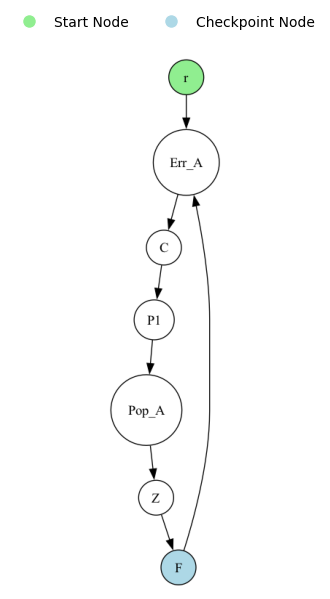

In [618]:
from humancompatible.interconnect.simulators.simulation import Simulation
sim = Simulation()

sim.system.add_nodes([refsig, agg1, agg2, cont, pop1, delay, fil])
sim.system.connect_nodes(refsig, agg1)
sim.system.connect_nodes(agg1, cont)
sim.system.connect_nodes(cont, pop1)
sim.system.connect_nodes(pop1, agg2)
sim.system.connect_nodes(agg2, delay)
sim.system.connect_nodes(delay, fil)
sim.system.connect_nodes(fil, agg1)

sim.system.set_start_node(refsig)
sim.system.set_checkpoint_node(fil)

sim.plot.render_graph()

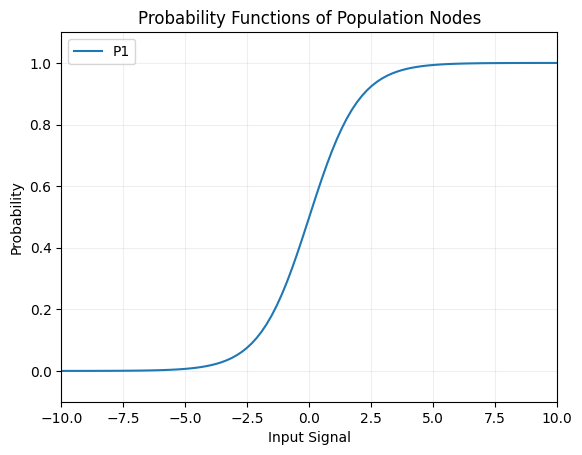

In [619]:
sim.plot.population_probabilities(xMin=-10, xMax=10)

In [620]:
sim.system.run(20)

Running Control System: 100%|██████████| 20/20 [00:00<00:00, 4972.50it/s]


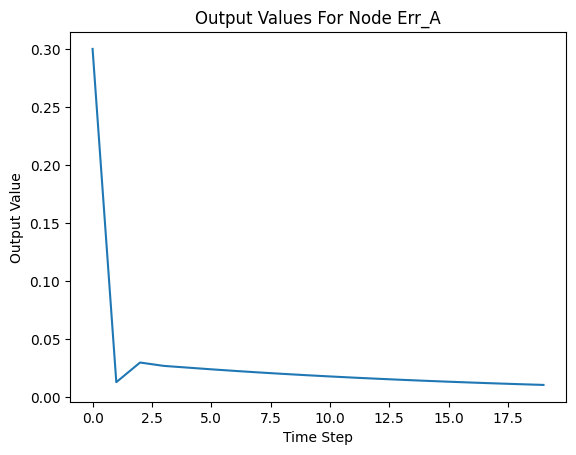

In [621]:
sim.plot.node_outputs(agg1)

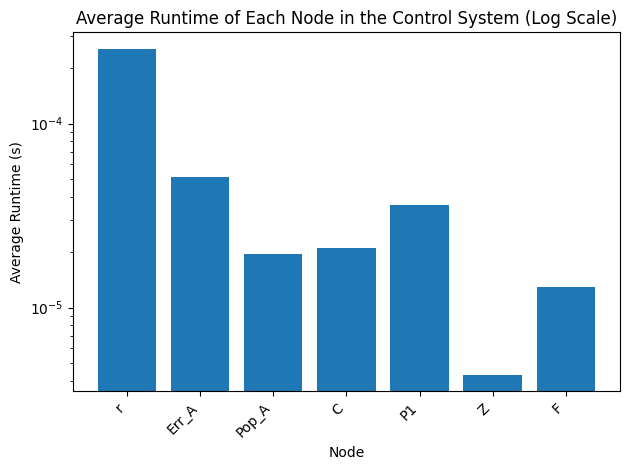

In [622]:
sim.plot.runtimes()

In [623]:
refsig.outputValue, agg1.outputValue, cont.outputValue, pop1.outputValue, agg2.outputValue, delay.outputValue, fil.outputValue

(tensor([0.3000], requires_grad=True),
 tensor([0.0104], requires_grad=True),
 tensor([0.3244], grad_fn=<AddBackward0>),
 tensor([0.5804], grad_fn=<DivBackward0>),
 tensor([0.5804], grad_fn=<UnsqueezeBackward0>),
 tensor([0.5804], grad_fn=<UnsqueezeBackward0>),
 tensor([-0.2902], grad_fn=<DivBackward0>))

In [624]:
inputValue = (cont.logic.tensors["kp"], cont.logic.tensors["ki"], cont.logic.tensors["e"], cont.outputValue, pop1.outputValue)
outputValue = fil.outputValue

torch.autograd.grad(inputs=inputValue, outputs=outputValue)

(tensor([-0.0013]),
 tensor([-0.0777]),
 tensor([-0.1218]),
 tensor([-0.1218]),
 tensor([-0.5000]))

In [625]:
from torchviz import make_dot

graph = make_dot(fil.logic.result, params=dict(refsig=refsig.outputValue, 
                                          result=agg1.logic.result,
                                          kp=cont.logic.tensors["kp"],
                                          ki=cont.logic.tensors["ki"],
                                          x=cont.logic.tensors["x"],
                                          s1=pop1.logic.tensors["s_const1"],
                                          s2=pop1.logic.tensors["s_const2"],
                                          K=fil.logic.tensors["K"],
                                          output=fil.logic.result))
graph.render("computation_graph", view=True)

'computation_graph.pdf'